## Question 1-2 Train on actual tasks 
Requirements: 
* visualize the training process by showing both loss and accuracy on two charts
* use MNIST or CIFAR-10
* use CNN or DNN

<b>Report Questions:</b>
* Describe the models you use and the task you chose. 
* In one chart, plot the training loss of all models. 
* In one chart, plot the training accuracy. 
* Comment on your results. 
* Use more than two models in all previous questions. (bonus )
* Train on more than one task. (bonus )



In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random 
import string
import os

import torch
import torchvision # Use built-in data 
from torchvision import transforms, datasets
import torch.nn as nn # contain trainable parameters
import torch.nn.functional as F #  purely functional.
import torch.nn.init as init
import torch.optim as optim
from torch.optim import SGD, Adam
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA




In [2]:
n_epochs = 100
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 500 # print the performance (loss) per 500 batches

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

device = torch.device("cuda")

In [3]:
compose_func = [transforms.ToTensor(),
                transforms.Normalize((0.1307,),(0.3081,))]#0.1307,0.3081: global mean and std of MNIST

train = datasets.MNIST("./data", train=True, download=True, 
                       transform=transforms.Compose(compose_func)) # transform data to tensor
test = datasets.MNIST("./data", train=False, download=True,
                     transform=transforms.Compose(compose_func))

In [4]:
trainset = torch.utils.data.DataLoader(train, batch_size=batch_size_train, shuffle=True) # load and train data
testset = torch.utils.data.DataLoader(test, batch_size=batch_size_test, shuffle=True) 

In [5]:
# https://gist.github.com/jeasinema/ed9236ce743c8efaf30fa2ff732749f5
def init_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            init.xavier_normal_(m.weight.data)
            if m.bias is not None:
                init.normal_(m.bias.data)
        elif isinstance(m, nn.BatchNorm2d):
            init.normal_(m.weight.data, mean=1, std=0.02)
            init.constant_(m.bias.data, 0)
        elif isinstance(m, nn.Linear):
            init.xavier_normal_(m.weight.data)
            init.normal_(m.bias.data)

In [6]:
def train(trainset, model, criterion, optimizer, epoch, 
             epoch_ls, accu): # get accuracy, loss, gradient norm

    running_loss = 0.0
    total = 0.0
    correct = 0
    for batch_idx, (data, target) in enumerate(trainset):
        optimizer.zero_grad() #Set the gradients to zero
        
        data = data.to(device)
        target = target.to(device)
        
        # forward pass
        output = model(data) #The outputs are energies for the 10 classes.
        ls = criterion(output, target)
        
        # metrics 
        running_loss += ls.item()
        
        original = target
        _, predicted =  torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted==original).sum().item()
        
        # backward pass
        ls.backward()
        optimizer.step()# adjust the weights for us
        
    accu.append(correct/total)
    epoch_ls.append(running_loss/len(trainset))
    print("Epoch: ", epoch,"\tAccuracy: ", correct/total, "\tLoss: ", running_loss/len(trainset))

In [7]:
def test(testset, model, criterion,
        test_epoch_losses, test_epoch_accuracy):
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():  # no gradients: for testing data. we don't need to optimize 
        for data, target in testset:
            data = data.to(device)
            target = target.to(device)
        
            output = model(data)
            ls = criterion(output, target)
            
            # metrics 
            running_loss += ls.item()

            original = target
            _, predicted =  torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted==original).sum().item()
        
        test_epoch_losses.append(running_loss/len(testset))
        test_epoch_accuracy.append(correct/total)
            
    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
      correct, total,
      100 * correct / total))

Model 0

Model 1

In [14]:
# https://www.kaggle.com/akhileshrai/intro-cnn-pytorch-pca-tnse-isomap/data?select=test.csv
class ConvNet1(nn.Module):
    def __init__(self):
        super(ConvNet1, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [15]:
m1 = ConvNet1().to(device)
m1.apply(init_weights)
optimizer1 = SGD(m1.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

ls_tr1, ls_te1, ac_tr1, ac_te1 = [],[],[],[]

n_epochs = 50
for epoch in range(1, n_epochs + 1):
    train(trainset, m1, criterion, optimizer1, epoch, 
             ls_tr1, ac_tr1)
    test(testset, m1, criterion, ls_te1, ac_te1)
    


Epoch:  1 	Accuracy:  0.95405 	Loss:  0.16276336926966906

Test set: Accuracy: 9818/10000 (98%)

Epoch:  2 	Accuracy:  0.9816833333333334 	Loss:  0.06136307472845655

Test set: Accuracy: 9847/10000 (98%)

Epoch:  3 	Accuracy:  0.9857166666666667 	Loss:  0.047599920822652

Test set: Accuracy: 9871/10000 (99%)

Epoch:  4 	Accuracy:  0.9884666666666667 	Loss:  0.03925157448106598

Test set: Accuracy: 9884/10000 (99%)

Epoch:  5 	Accuracy:  0.9896166666666667 	Loss:  0.034443958902603454

Test set: Accuracy: 9874/10000 (99%)

Epoch:  6 	Accuracy:  0.9916166666666667 	Loss:  0.029168566166081215

Test set: Accuracy: 9885/10000 (99%)

Epoch:  7 	Accuracy:  0.9922666666666666 	Loss:  0.026341414411312967

Test set: Accuracy: 9897/10000 (99%)

Epoch:  8 	Accuracy:  0.9933666666666666 	Loss:  0.023786732164680212

Test set: Accuracy: 9891/10000 (99%)

Epoch:  9 	Accuracy:  0.9942166666666666 	Loss:  0.021342291115675923

Test set: Accuracy: 9902/10000 (99%)

Epoch:  10 	Accuracy:  0.99475 	Loss

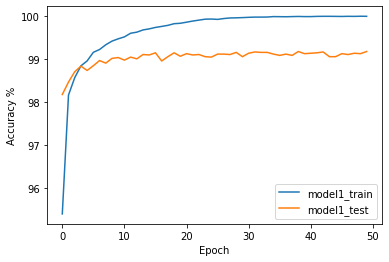

In [29]:
# accuracy 
# plt.plot(np.asarray(ac_tr0)*100, label = "model0_train")
# plt.plot(np.asarray(ac_te0)*100, label = "model0_test")
plt.plot(np.asarray(ac_tr1)*100, label = "model1_train")
plt.plot(np.asarray(ac_te1)*100, label = "model1_test")
# plt.plot(np.asarray(ac_tr2)*100, label = "model2_train")
# plt.plot(np.asarray(ac_te2)*100, label = "model2_test")

plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.legend()
plt.show()

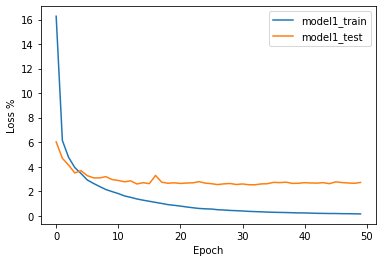

In [30]:
# Loss 
# plt.plot(np.asarray(ac_tr0)*100, label = "model0_train")
# plt.plot(np.asarray(ac_te0)*100, label = "model0_test")
plt.plot(np.asarray(ls_tr1)*100, label = "model1_train")
plt.plot(np.asarray(ls_te1)*100, label = "model1_test")
# plt.plot(np.asarray(ac_tr2)*100, label = "model2_train")
# plt.plot(np.asarray(ac_te2)*100, label = "model2_test")

plt.xlabel('Epoch')
plt.ylabel('Loss %')
plt.legend()
plt.show()